In [2]:
#setup (all libraries needed are loaded here)
import pandas as pd #for dataframes and general data stuffs
import matplotlib.pyplot as plt #for plots, also for seaborn?
import seaborn as sns #for other plots
import numpy as np #for some trivial statistics
from factor_analyzer import FactorAnalyzer #we're going to do and report a factor analysis of the instrument
import statistics #for some fancy statistics

# Analysis of the school belonging data

The goal of this analysis is to get the score of belonging for each participant - the bigger the score the stronger the sense of school belonging. Or so we hope.
In order to get the score we first need to 'translate' the data collected with the survey into numbers and run a factor analysis on those numbers. Then, from the factor scores we can decide if all the statements in the belonging instrument are valid representation of the variable that we call school belonging.

In [8]:
#import data from survey
reflex = pd.read_csv(r'Data/reflex.csv', sep=';')
#filtering data according to participants consent
reflex = reflex[reflex[
                    'Käesoleva.küsimustiku.andmeid.kasutatakse.teadustöös...Analüüsi.tulemusi.kajastatakse.teadusartiklis.anonüümselt.ja.neid.ei.edastata.kolmandatele.isikutele....Olen.nõus..et.minu.vastuseid.kasutatakse.teadustöös.'] == 'Jah']

In [9]:
#take a look at the columns to see which ones are the belonging
reflex.columns

Index(['Vastuse.ID', 'Kinnitamise.kuupäev', 'Viimane.lehekülg',
       'Alustamise.keel', 'Alustamise.kuupäev', 'Viimase.tegevuse.kuupäev',
       'IP.aadress',
       'Käesoleva.küsimustiku.andmeid.kasutatakse.teadustöös...Analüüsi.tulemusi.kajastatakse.teadusartiklis.anonüümselt.ja.neid.ei.edastata.kolmandatele.isikutele....Olen.nõus..et.minu.vastuseid.kasutatakse.teadustöös.',
       'Eesnimi', 'Perenimi',
       'Palun.märgi..mil.määral.nõustud.järgmiste.väidetega...Mul.on.olemas.vajalikud.teadmised.ja.oskused..et.ülikoolis.hakkama.saada.',
       'Palun.märgi..mil.määral.nõustud.järgmiste.väidetega...Ülikoolis.õppimine.on.väga.huvitav.ja.köitev.',
       'Palun.märgi..mil.määral.nõustud.järgmiste.väidetega...Ma.töötan.kõvasti.heade.akadeemiliste.tulemuste.nimel.',
       'Palun.märgi..mil.määral.nõustud.järgmiste.väidetega...Ma.olen.võimeline.saama.enamikus.ainetes.häid.tulemusi.',
       'Palun.märgi..mil.määral.nõustud.järgmiste.väidetega...Vajadusel.loobun.muudest.tegevustest.h

In [10]:
belonging = reflex.iloc[:,18:24]
#the columns (also the statements) are as following
bl_statements = []
for col in belonging.columns:
    title, statement = col.split('...')
    statement = statement.strip('.')
    bl_statements.append(statement)
bl_statements = pd.DataFrame(bl_statements)
print(bl_statements)

                                          0
0    Ma.leian..et.teised.peavad.minust.lugu
1                   Ma.leian.kergesti.sõpru
2  Ma.tunnen..et.olen.osa.sellest.kursusest
3  Ma.tunnen.end.koolis.kohmaka.ja.kohatuna
4          Ma.tunnen.end.ülikoolis.üksikuna
5         Ma.tunnen.end.ülikoolis.tõrjutuna


In [11]:
#lets look at the scale used in this instrument. any statement that has the full range will give us that
set(reflex['Palun.märgi..mil.määral.nõustud.järgnevate.väidetega...Ma.tunnen.end.koolis.kohmaka.ja.kohatuna..'])

{'Ei nõustu üldse',
 'Ei oska öelda',
 'Nõustun täielikult',
 'Pigem ei nõustu',
 'Pigem nõustun'}

In [13]:
#create the ordered list of scale values
levels_bl = ['Ei nõustu üldse','Pigem ei nõustu','Ei oska öelda', 'Pigem nõustun','Nõustun täielikult']

#rename the columns with shorter indicators to make the code more readable
belonging.columns = ['bl1','bl2','bl3','bl4','bl5','bl6']

#the dictionary to make the replacements
belonging_replacer = {'Ei nõustu üldse':1,
                      'Ei oska öelda':3,
                      'Pigem ei nõustu':2,
                      'Pigem nõustun':4,
                      'Nõustun täielikult':5}

#new dataframe with numbers
belonging0 = belonging.replace({'bl1':belonging_replacer,'bl2':belonging_replacer,'bl3':belonging_replacer,'bl4':belonging_replacer,'bl5':belonging_replacer,'bl6':belonging_replacer,})

In [14]:
#recalculate (reverse code) the last 3 statements. this is later needed to calculate the chronbach's alpha
belonging0['bl4_'] = 6 - belonging0['bl4']
belonging0['bl5_'] = 6 - belonging0['bl5']
belonging0['bl6_'] = 6 - belonging0['bl6']

In [15]:
#take a subset (we don't need the original numbers anymore
belonging_recoded = belonging0.loc[:,['bl1','bl2','bl3','bl4_','bl5_','bl6_']]
fa = FactorAnalyzer(n_factors = 1, rotation = None, method = 'ml')
fa_belong = fa.fit(belonging_recoded)
fa_belong.loadings_

array([[-0.38818339],
       [-0.59363663],
       [-0.61787276],
       [-0.62307168],
       [-0.817136  ],
       [-0.53356417]])

In [28]:
#looking at the factor scores we could argue that the first statement is not doing much for the subjects.
# let's take a look at the statement to see what might be the reason
bl_statements[:1]

,0
0,Ma.leian..et.teised.peavad.minust.lugu


In [29]:
#this might not be the best statement to have young people agreeing on. we will leave it out
belonging_recoded1 = belonging_recoded.loc[:,['bl2','bl3','bl4_','bl5_','bl6_']]

In [32]:
#...and run the factor analysis once more
fa = FactorAnalyzer(n_factors = 1, rotation = None, method = 'ml')
bl_fa = fa.fit(belonging_recoded1)
bl_loadings = pd.DataFrame(bl_fa.loadings_)
bl_loadings

,0
0,-0.581549
1,-0.610048
2,-0.606219
3,-0.853426
4,-0.511765


In [34]:
#new list of statements without the first one.
bl_statements1 = bl_statements[1:].reset_index(drop=True)
bl_statements1

,0
0,Ma.leian.kergesti.sõpru
1,Ma.tunnen..et.olen.osa.sellest.kursusest
2,Ma.tunnen.end.koolis.kohmaka.ja.kohatuna
3,Ma.tunnen.end.ülikoolis.üksikuna
4,Ma.tunnen.end.ülikoolis.tõrjutuna


In [35]:
#lets print them side-by-side to look at them in all their glory
pd.concat([bl_loadings, bl_statements1], axis = 1)

,0,0
0,-0.581549,Ma.leian.kergesti.sõpru
1,-0.610048,Ma.tunnen..et.olen.osa.sellest.kursusest
2,-0.606219,Ma.tunnen.end.koolis.kohmaka.ja.kohatuna
3,-0.853426,Ma.tunnen.end.ülikoolis.üksikuna
4,-0.511765,Ma.tunnen.end.ülikoolis.tõrjutuna


In [36]:
#we calculate the factorscore (three first as they are, ignoring the three in the middle and using the last three as they are reversed)
#using a simple sum
belonging_recoded1['score'] = belonging_recoded1.sum(axis = 1)

In [37]:
#lets print out some general statistics
print("The general statistics for the belonging instrument are as following")
print(f"Max {max(belonging_recoded1['score'])}")
print(f"Min {min(belonging_recoded1['score'])}")
print(f"Standard deviation {round(np.std(belonging_recoded1['score']),2)}")
print(f"Mean {round(np.mean(belonging_recoded1['score']),2)}")
print(f"Mode {statistics.mode(belonging_recoded1['score'])}")
print(f"Median {np.median(belonging_recoded1['score'])}")
print(f"N = {len(belonging_recoded1)}")

The general statistics for the belonging instrument are as following
Max 25
Min 6
Standard deviation 3.65
Mean 18.52
Mode 18
Median 19.0
N = 153


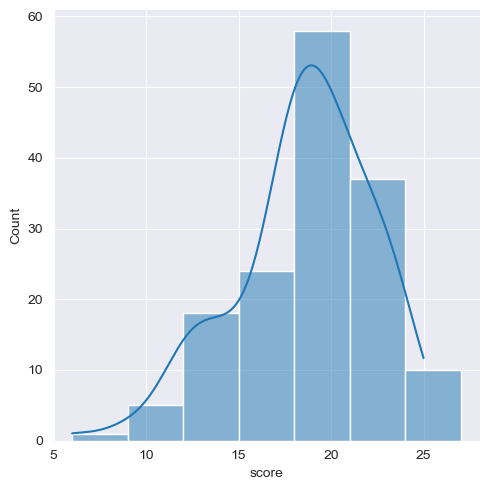

In [38]:
sns.displot(belonging_recoded1, x = 'score', kde = True, binwidth = 3)
plt.show()

In [39]:
#the original data has participant names as the last column. we will need it later to merge with other data
names = reflex.iloc[:,-1]
#add the name column
belonging_recoded1['name'] = names
#only select the name and score
belonging_scores = belonging_recoded1.loc[:,['name','score']]
#save to file just in case
belonging_scores.to_csv('belonging_scores.csv', index = False)